In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression

from PIL import Image

# constants
repo_path = Path('/Users/etriesch/dev/tree-finder/')
model_path = repo_path / 'models'

# disable image processing warning
Image.MAX_IMAGE_PIXELS = None

In [7]:
# setup cell
USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 200
print('using device:', device)

using device: cpu


In [8]:
# setup cell
from plot_fns import show_image_batch, set_plt_settings
from train_fns import flatten, Flatten, check_accuracy, train_model

# And change jupyter settings to auto-reload these functions before each instance running them
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [72]:
# make dataset
SCALE = 1024
CROP = SCALE
SCALE_TEMP = 256 # for training

# define transformations
transforms = {}
transforms['orig'] = T.Compose([T.Resize(SCALE), T.CenterCrop(CROP), 
                       T.Resize(SCALE_TEMP),
                       T.ToTensor()])
transforms['mirr'] = T.Compose([T.Resize(SCALE), T.CenterCrop(CROP), T.RandomHorizontalFlip(1), 
                       T.Resize(SCALE_TEMP),
                       T.ToTensor()])

# include a random cropping (flipped and unflipped) at three crop sizes
for pct in [10, 25, 50]:
    scale_param = int(1 / (pct*0.01))
    transforms[f'crop{pct}'] = T.Compose([T.Resize(scale_param*SCALE), T.RandomResizedCrop(CROP),
                                          T.Resize(SCALE_TEMP),
                                          T.ToTensor()])
    transforms[f'crop{pct}_mirr'] = T.Compose([T.Resize(scale_param*SCALE), T.RandomResizedCrop(CROP),
                                               T.RandomHorizontalFlip(1),
                                               T.Resize(SCALE_TEMP),
                                               T.ToTensor()])

In [73]:
# create dataset by concatenating all transformations
binds = []
for t in transforms:
    df = dset.ImageFolder(root=repo_path / 'data/images_bin', transform=transforms[t])
    binds.append(df)

binds = ConcatDataset(binds)

In [74]:
# make dataloaders
PCT_TRAIN, PCT_VAL = 0.75, 0.15
N = len(binds)
num_train = int(N * PCT_TRAIN)
num_val = int(N * PCT_VAL)
num_test = N - num_train - num_val
print('(train, val, test):', num_train, num_val, num_test)


# make loaders
loader_all = DataLoader(dataset=binds, batch_size=N, shuffle=False)
loader_train = DataLoader(binds, batch_size=64,
                           sampler=sampler.SubsetRandomSampler(range(num_train)))
loader_val = DataLoader(binds, batch_size=64,
                           sampler=sampler.SubsetRandomSampler(range(num_train, num_train+num_val)))
loader_test = DataLoader(binds, batch_size=64,
                           sampler=sampler.SubsetRandomSampler(range(num_train+num_val, N)))

(train, val, test): 2352 470 314


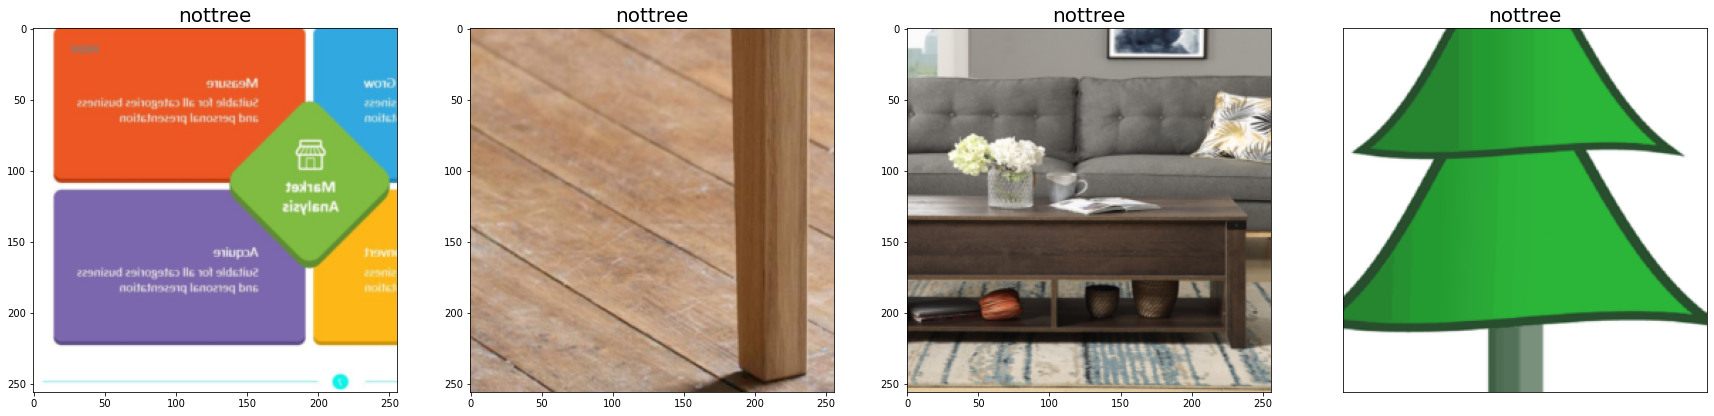

In [78]:
# visualize images
loader_samp = DataLoader(dataset=binds, batch_size=4, shuffle=True)

trainiter = iter(loader_samp)
imgs, labels = trainiter.next()

# print(type(imgs), type(labels))
show_image_batch(imgs, title=[classes[x] for x in labels])

# Retrain a pretrained model for binary classification of trees

In [82]:
pt_net = models.resnet18(pretrained=True) # https://pytorch.org/vision/stable/models.html

In [83]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pt_net.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = pt_net.fc.in_features
pt_net.fc = nn.Linear(num_ftrs, 128)

In [89]:
n_epochs = 3
print_every = 100
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(loader_train)

In [90]:
%timeit
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'===== Epoch {epoch} =====')
    for batch_idx, (data_, target_) in enumerate(loader_train):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = pt_net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    
    with torch.no_grad():
        pt_net.eval()
        for data_t, target_t in (loader_val):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = pt_net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(pt_net.state_dict(), model_path / 'resnet.pt')
            print('Improvement-Detected, save-model')
    pt_net.train()

===== Epoch 1 =====
Epoch [1/3], Step [0/37], Loss: 4.6411


KeyboardInterrupt: 